<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#The-example" data-toc-modified-id="The-example-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The example</a></span></li><li><span><a href="#W_{self}---w_{next}-evolution" data-toc-modified-id="W_{self}---w_{next}-evolution-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>W_{self} - w_{next} evolution</a></span></li><li><span><a href="#The-plot" data-toc-modified-id="The-plot-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>The plot</a></span></li></ul></li><li><span><a href="#Generate-the-individual-plots-and-save-them" data-toc-modified-id="Generate-the-individual-plots-and-save-them-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate the individual plots and save them</a></span></li><li><span><a href="#A-quick-plot-for-the-how-P_next-behaves-as-a-function-of-tau_z" data-toc-modified-id="A-quick-plot-for-the-how-P_next-behaves-as-a-function-of-tau_z-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A quick plot for the how P_next behaves as a function of tau_z</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [2]:
epsilon = 1e-7
vmin = -6.0
remove = 0.010
g_a_big = 3.0

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 100.0
g_a = 5.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

In [3]:
from connectivity_functions import softmax, get_w_pre_post, get_beta, strict_max


class Network2:
    def __init__(self, hypercolumns, minicolumns, G=1.0, tau_s=0.010, tau_z_pre=0.050, tau_z_post=0.005,
                 tau_a=0.250, tau_p=10.0, g_a=1.0, g_I=10.0, sigma_out=0.0, epsilon=1e-60, g_beta=1.0, prng=np.random,
                 strict_maximum=True, perfect=False, normalized_currents=True):

        # Random number generator
        self.prng = prng
        self.sigma_out = sigma_out   # The variance that the system would have on the steady state if were to have it
        self.sigma_in = sigma_out * np.sqrt(2 / tau_s)    # Ornstein-Uhlenbeck process
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Network variables
        self.strict_maximum = strict_maximum
        self.perfect = perfect
        self.normalized_current = normalized_currents
        if self.normalized_current:
            self.normalized_constant = self.hypercolumns
        else:
            self.normalized_constant = 1.0

        #  Dynamic Parameters
        self.tau_s = tau_s
        self.tau_a = tau_a
        self.tau_p = tau_p
        self.r = self.tau_s / self.tau_a
        self.g_beta = g_beta
        self.g_a = g_a
        self.g_I = g_I
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.G = G

        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)
        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        # Keeping track of the probability / connectivity
        self.t_p = 0.0
        self.p_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.p_post = np.full(shape=self.n_units, fill_value=0.0)
        self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.beta = np.full(shape=self.n_units, fill_value=0.0)

    def parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_s': self.tau_s, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_a': self.tau_a, 'g_a': self.g_a, 'g_I':self.g_I,  'epsilon': self.epsilon,
                      'G': self.G, 'sigma_out':self.sigma_out, 'sigma_in': self.sigma_in,
                      'perfect': self.perfect, 'strict_maximum': self.strict_maximum}

        return parameters

    def reset_values(self, keep_connectivity=True):
        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)

        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        if not keep_connectivity:
            self.beta = np.full(shape=self.n_units, fill_value=0.0)
            self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

            self.p_pre = np.full(shape=self.n_units, fill_vale=0.0)
            self.p_post = np.full(shape=self.n_units, fill_value=0.0)
            self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

    def update_continuous(self, dt=1.0, sigma=None):
        # Get the noise
        if sigma is None:
            noise = self.sigma_in * np.sqrt(dt) * self.prng.normal(0, 1.0, self.n_units)
        else:
            noise = sigma

        # Calculate currents
        self.i = self.w @ self.o / self.normalized_constant
        if self.perfect:
            self.s = self.i + self.g_beta * self.beta - self.g_a * self.a + self.g_I * self.I + noise
        else:
            self.s += (dt / self.tau_s) * (self.i  # Current
                                           + self.g_beta * self.beta  # Bias
                                           + self.g_I * self.I  # Input current
                                           - self.g_a * self.a  # Adaptation
                                           - self.s)  # s follow all of the s above
            self.s += noise
        # Non-linearity
        if self.strict_maximum:
            self.o = strict_max(self.s, minicolumns=self.minicolumns)
        else:
            self.o = softmax(self.s, G=self.G, minicolumns=self.minicolumns)

        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

    def update_z_values(self, dt):
        # Updated the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)

    def update_probabilities(self, dt):
        self.p_pre += (dt / self.tau_p) * (self.z_pre - self.p_pre)
        self.p_post += (dt / self.tau_p) * (self.z_post - self.p_post)
        self.P += (dt / self.tau_p) * (self.z_co - self.P)

    def update_weights(self):
        # Update the connectivity
        self.beta = get_beta(self.p_post, self.epsilon)
        self.w = get_w_pre_post(self.P, self.p_pre, self.p_post, self.epsilon, diagonal_zero=False)

In [4]:
class Network:
    def __init__(self, hypercolumns, minicolumns, G=1.0, tau_s=0.010, tau_z_pre=0.050, tau_z_post=0.005,
                 tau_a=0.250, g_a=1.0, g_I=10.0, sigma_out=0.0, epsilon=1e-60, g_beta=1.0, prng=np.random,
                 strict_maximum=True, perfect=False, normalized_currents=True):

        # Random number generator
        self.prng = prng
        self.sigma_out = sigma_out   # The variance that the system would have on the steady state if were to have it
        self.sigma_in = sigma_out * np.sqrt(2 / tau_s)    # Ornstein-Uhlenbeck process
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Network variables
        self.strict_maximum = strict_maximum
        self.perfect = perfect
        self.normalized_current = normalized_currents
        if self.normalized_current:
            self.normalized_constant = self.hypercolumns
        else:
            self.normalized_constant = 1.0

        #  Dynamic Parameters
        self.tau_s = tau_s
        self.tau_a = tau_a
        self.r = self.tau_s / self.tau_a
        self.g_beta = g_beta
        self.g_a = g_a
        self.g_I = g_I
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.G = G

        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)
        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        # Keeping track of the probability / connectivity
        self.t_p = 0.0
        self.p_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.p_post = np.full(shape=self.n_units, fill_value=0.0)
        self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.beta = np.full(shape=self.n_units, fill_value=0.0)

    def parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_s': self.tau_s, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_a': self.tau_a, 'g_a': self.g_a, 'g_I':self.g_I,  'epsilon': self.epsilon,
                      'G': self.G, 'sigma_out':self.sigma_out, 'sigma_in': self.sigma_in,
                      'perfect': self.perfect, 'strict_maximum': self.strict_maximum}

        return parameters

    def reset_values(self, keep_connectivity=True):
        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)

        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        if not keep_connectivity:
            self.beta = np.full(shape=self.n_units, fill_value=0.0)
            self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

            self.p_pre = np.full(shape=self.n_units, fill_vale=0.0)
            self.p_post = np.full(shape=self.n_units, fill_value=0.0)
            self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

    def update_continuous(self, dt=1.0, sigma=None):
        # Get the noise
        if sigma is None:
            noise = self.sigma_in * np.sqrt(dt) * self.prng.normal(0, 1.0, self.n_units)
        else:
            noise = sigma

        # Calculate currents
        self.i = self.w @ self.o / self.normalized_constant
        if self.perfect:
            self.s = self.i + self.g_beta * self.beta - self.g_a * self.a + self.g_I * self.I + noise
        else:
            self.s += (dt / self.tau_s) * (self.i  # Current
                                           + self.g_beta * self.beta  # Bias
                                           + self.g_I * self.I  # Input current
                                           - self.g_a * self.a  # Adaptation
                                           - self.s)  # s follow all of the s above
            self.s += noise
        # Non-linearity
        if self.strict_maximum:
            self.o = strict_max(self.s, minicolumns=self.minicolumns)
        else:
            self.o = softmax(self.s, G=self.G, minicolumns=self.minicolumns)

        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

    def update_z_values(self, dt):
        # Updated the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)
   
    def update_probabilities(self, dt):
        if self.t_p > 0.0:
            time_factor = dt / self.t_p
            self.p_pre += time_factor * (self.z_pre - self.p_pre)
            self.p_post += time_factor * (self.z_post - self.p_post)
            self.P += time_factor * (self.z_co - self.P)
        self.t_p += dt

    def update_weights(self):
        # Update the connectivity
        self.beta = get_beta(self.p_post, self.epsilon)
        self.w = get_w_pre_post(self.P, self.p_pre, self.p_post, self.epsilon, diagonal_zero=False)

In [148]:
def plot_matrix(w, one_hypercolum=True, ax=None, vmin=None, vmax=None, title=True, transpose=False, colorbar=True):
    with sns.axes_style("whitegrid", {'axes.grid': False}):

        w = w

        # aux_max = np.max(np.abs(w))
        norm = MidpointNormalize(midpoint=0)
        cmap = matplotlib.cm.RdBu_r

        if ax is None:
            # sns.set_style("whitegrid", {'axes.grid': False})
            fig = plt.figure()
            ax = fig.add_subplot(111)
        if transpose:
            matrix_to_plot = w.T
        else:
            matrix_to_plot = w
        im = ax.imshow(matrix_to_plot, cmap=cmap, interpolation='None', norm=norm, vmin=vmin, vmax=vmax)

        if title:
            ax.set_title('w connectivity')

        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cb = ax.get_figure().colorbar(im, ax=ax, cax=cax)

    return ax

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## The example

In [25]:
sigma_out = 0.00
tau_z_pre = 0.050
tau_z_post = 0.005
tau_p = 5.0
g_a = 2.0

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.00
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0
resting_time = 0.0
epochs = 50
T_persistence = 0.100

# Manager properties
values_to_save = ['s', 'o', 'w', 'z_pre', 'beta', 'p_post', 'p_pre', 'P']


# Neural Network
nn = Network2(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, tau_p=tau_p, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
manager.run_network_protocol(protocol=protocol, plasticity_on=True)
# Set the persistent time

../network.py:349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:
../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


epochs 0
epochs 1
epochs 2
epochs 3
epochs 4
epochs 5
epochs 6
epochs 7
epochs 8
epochs 9
epochs 10
epochs 11
epochs 12
epochs 13
epochs 14
epochs 15
epochs 16
epochs 17
epochs 18
epochs 19
epochs 20
epochs 21
epochs 22
epochs 23
epochs 24
epochs 25
epochs 26
epochs 27
epochs 28
epochs 29
epochs 30
epochs 31
epochs 32
epochs 33
epochs 34
epochs 35
epochs 36
epochs 37
epochs 38
epochs 39
epochs 40
epochs 41
epochs 42
epochs 43
epochs 44
epochs 45
epochs 46
epochs 47
epochs 48
epochs 49


## W_{self} - w_{next} evolution

In [37]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
P = manager.history['P']
s = manager.history['s']
beta = manager.history['beta']

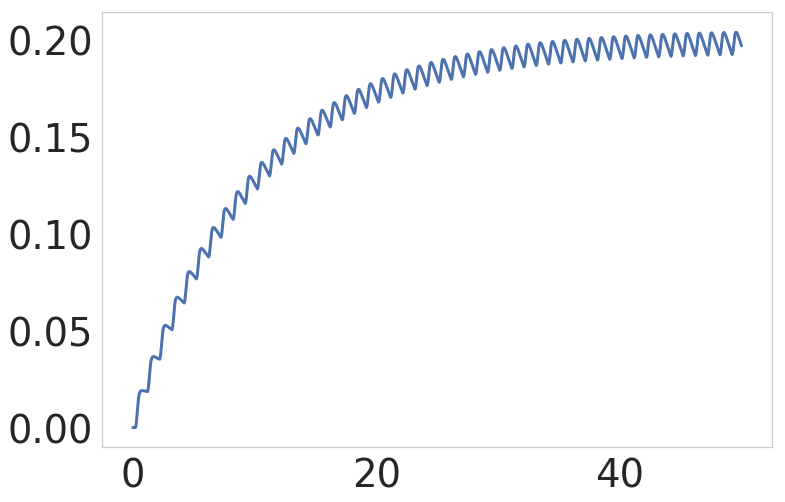

In [38]:
delta_w = w[1, 1] - w[2, 1]
plt.plot(manager.time / (training_times_base * n_patterns), p_pre_to_plot, lw=3, label=r'$p_{pre}$')

Text(0.5, 0, 'Epochs')

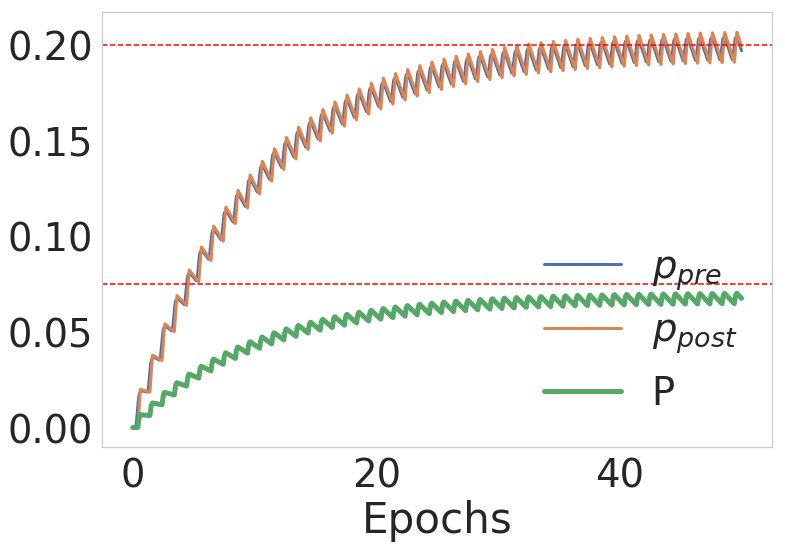

In [88]:
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]


plt.plot(manager.time / (training_times_base * n_patterns), p_pre_to_plot, lw=3, label=r'$p_{pre}$')
plt.plot(manager.time / (training_times_base * n_patterns), p_post_to_plot, lw=3, label=r'$p_{post}$')
plt.plot(manager.time / (training_times_base * n_patterns), P_to_plot, lw=5, label='P')

plt.legend(frameon=False)


P_steady = (1 - np.exp(-training_times_base / tau_z_pre)) * (1 - np.exp(-training_times_base / tau_z_pre))
P_steady *= (tau_z_pre  / (n_patterns * training_times_base))

plt.axhline(0.20, ls='--', color='red', label=r'$p_{steady}$')
plt.axhline(P_steady, ls='--', color='red', label=r'$p_{steady}$' )

#plt.xlim([150, 158])
plt.xlabel('Epochs')
# plt.ylim([0, 0.1])b



(0, 1.5)

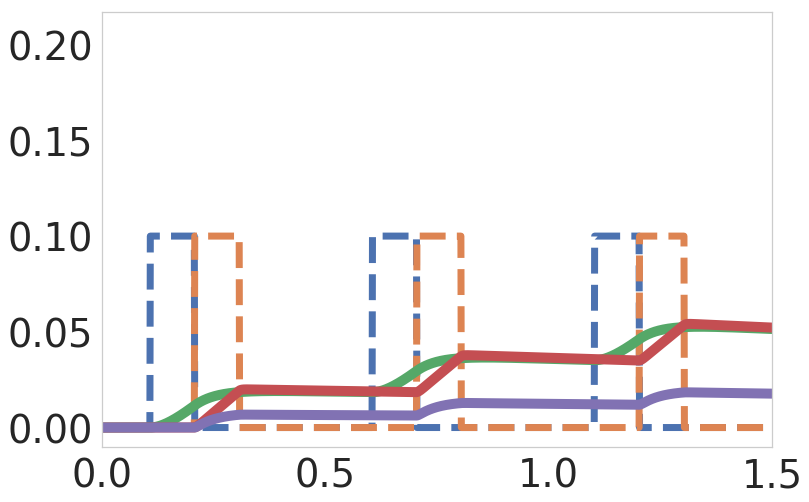

In [41]:
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]


plt.plot(manager.time, o[:, 1] / 10.0, lw=lw - 3, ls='--')
plt.plot(manager.time, o[:, 2] / 10.0, lw=lw - 3, ls='--') 

plt.plot(manager.time, p_pre_to_plot, lw=lw, label=r'$p_{pre}$')
plt.plot(manager.time, p_post_to_plot, lw=lw, label=r'$p_{post}$')
plt.plot(manager.time, P_to_plot, lw=lw, label='P')

plt.xlim([0, 1.5])


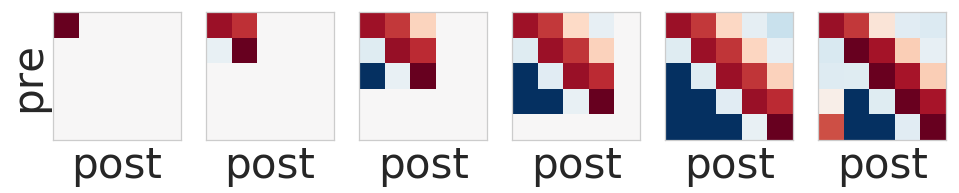

In [62]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 6)
fig = plt.figure(figsize=(16, 12))


for i in range(6):
    ax = fig.add_subplot(gs[0, i])

    t = (i + 1)/ 10.0
    n_to_plot = int(t/ dt)
    w_to_plot = w[n_to_plot, :, :]
    if i < 5:
        colorbar = False
    else:
        colorbar = False
    ax = plot_matrix(w_to_plot, ax=ax, title=False, colorbar=colorbar, transpose=True, vmin=vmin)
    ax.set_xlabel('post')
    if i == 0:
        ax.set_ylabel('pre')
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])

## The plot

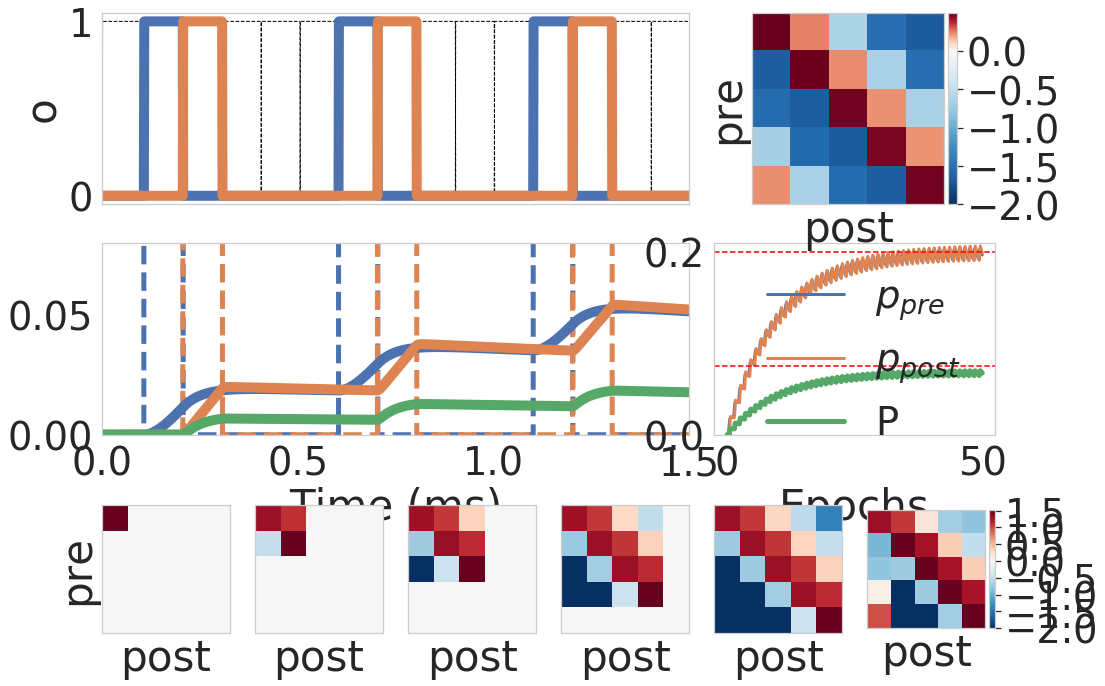

In [125]:
gs = gridspec.GridSpec(3, 6)
fig = plt.figure(figsize=(16, 12))

ax_o = fig.add_subplot(gs[0, 0:4])

for index in range(minicolumns):
    ax_o.plot(manager.time, o[:, index], lw=1, color='black', ls='--')

ax_o.plot(manager.time, o[:, 1], lw=lw, color=colors[0])
ax_o.plot(manager.time, o[:, 2], lw=lw, color=colors[1])
    
ax_o.set_ylabel('o')
ax_o.set_xlim([0.0, 1.5])
ax_o.xaxis.set_ticks([])

# The probabilities
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]
ax_prob = fig.add_subplot(gs[1, 0:4])

ax_prob.plot(manager.time, o[:, 1],  lw=lw - 5, color=colors[0], ls='--')
ax_prob.plot(manager.time, o[:, 2], lw=lw - 5,  color=colors[1], ls='--') 

ax_prob.plot(manager.time, p_pre_to_plot, color=colors[0], lw=lw, label=r'$p_{pre}$')
ax_prob.plot(manager.time, p_post_to_plot, color=colors[1], lw=lw, label=r'$p_{post}$')
ax_prob.plot(manager.time, P_to_plot, lw=lw, color=colors[2], label='P')

ax_prob.set_ylim([0, 0.08])
ax_prob.set_xlim([0, 1.5])

ax_prob.set_xlabel('Time (ms)')

# The steady state thing
ax_steady = fig.add_subplot(gs[1, 4:6])
ax_steady.plot(manager.time / (training_times_base * n_patterns), p_pre_to_plot, lw=3, label=r'$p_{pre}$')
ax_steady.plot(manager.time / (training_times_base * n_patterns), p_post_to_plot, lw=3, label=r'$p_{post}$')
ax_steady.plot(manager.time / (training_times_base * n_patterns), P_to_plot, lw=5, label='P')

ax_steady.legend(frameon=False)


P_steady = (1 - np.exp(-training_times_base / tau_z_pre)) * (1 - np.exp(-training_times_base / tau_z_pre))
P_steady *= (tau_z_pre  / (n_patterns * training_times_base))

ax_steady.axhline(0.20, ls='--', color='red', label=r'$p_{steady}$')
ax_steady.axhline(P_steady, ls='--', color='red', label=r'$p_{steady}$' )

ax_steady.set_xlabel('Epochs')
ax_steady.set_ylim([0, 0.21])
#ax_steady.yaxis.set_ticks([])

# The matrix at the end
vmin = -2.0
vmax = 1.0
ax_matrix = fig.add_subplot(gs[0, 4:6])
ax_matrix = plot_matrix(manager.nn.w, ax=ax_matrix, title=False, colorbar=True, transpose=True, vmin=vmin, vmax=vmax)
ax_matrix.yaxis.set_ticks([])
ax_matrix.xaxis.set_ticks([])
ax_matrix.set_xlabel('post')
ax_matrix.set_ylabel('pre')

# Evolution of the matrix
for i in range(6):
    ax = fig.add_subplot(gs[2, i])

    t = (i + 1)/ 10.0
    n_to_plot = int(t/ dt)
    w_to_plot = w[n_to_plot, :, :]
    if i < 5:
        colorbar = False
    else:
        colorbar = True
    ax = plot_matrix(w_to_plot, ax=ax, title=False, colorbar=colorbar, transpose=True, vmin=vmin, vmax=vmax)
    ax.set_xlabel('post')
    if i == 0:
        ax.set_ylabel('pre')
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])


#fig.tight_layout()

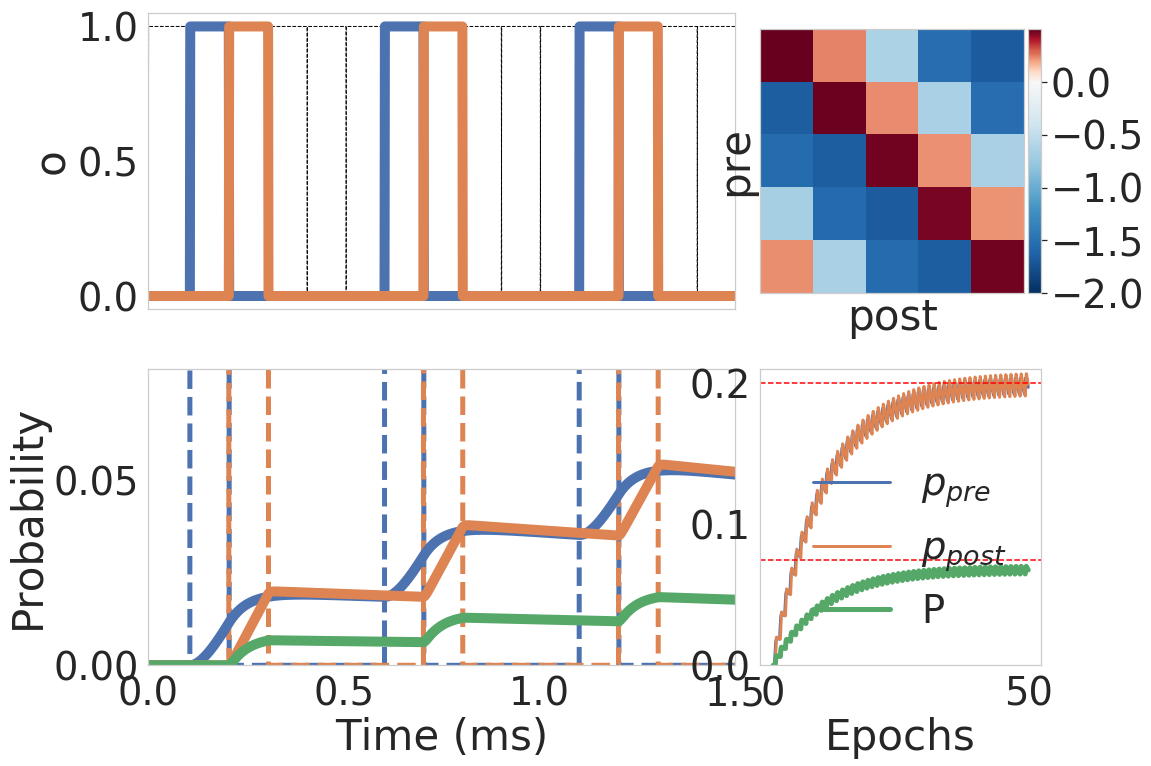

In [142]:
gs = gridspec.GridSpec(2, 6)
fig = plt.figure(figsize=(16, 12))

ax_o = fig.add_subplot(gs[0, 0:4])

for index in range(minicolumns):
    ax_o.plot(manager.time, o[:, index], lw=1, color='black', ls='--')

ax_o.plot(manager.time, o[:, 1], lw=lw, color=colors[0])
ax_o.plot(manager.time, o[:, 2], lw=lw, color=colors[1])
    
ax_o.set_ylabel('o')
ax_o.set_xlim([0.0, 1.5])
ax_o.xaxis.set_ticks([])

# The probabilities
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]
ax_prob = fig.add_subplot(gs[1, 0:4])

ax_prob.plot(manager.time, o[:, 1],  lw=lw - 5, color=colors[0], ls='--')
ax_prob.plot(manager.time, o[:, 2], lw=lw - 5,  color=colors[1], ls='--') 

ax_prob.plot(manager.time, p_pre_to_plot, color=colors[0], lw=lw, label=r'$p_{pre}$')
ax_prob.plot(manager.time, p_post_to_plot, color=colors[1], lw=lw, label=r'$p_{post}$')
ax_prob.plot(manager.time, P_to_plot, lw=lw, color=colors[2], label='P')

ax_prob.set_ylim([0, 0.08])
ax_prob.set_xlim([0, 1.5])
#ax_prob.yaxis.set_label_position("right")
ax_prob.set_xlabel('Time (ms)')
ax_prob.set_ylabel('Probability')


# The steady state thing
ax_steady = fig.add_subplot(gs[1, 4:6])
ax_steady.plot(manager.time / (training_times_base * n_patterns), p_pre_to_plot, lw=3, label=r'$p_{pre}$')
ax_steady.plot(manager.time / (training_times_base * n_patterns), p_post_to_plot, lw=3, label=r'$p_{post}$')
ax_steady.plot(manager.time / (training_times_base * n_patterns), P_to_plot, lw=5, label='P')

ax_steady.legend(frameon=False)


P_steady = (1 - np.exp(-training_times_base / tau_z_pre)) * (1 - np.exp(-training_times_base / tau_z_pre))
P_steady *= (tau_z_pre  / (n_patterns * training_times_base))

ax_steady.axhline(0.20, ls='--', color='red', label=r'$p_{steady}$')
ax_steady.axhline(P_steady, ls='--', color='red', label=r'$p_{steady}$' )

ax_steady.set_xlabel('Epochs')
ax_steady.set_ylim([0, 0.21])
#ax_steady.yaxis.set_ticks([])

# The matrix at the end
vmin = -2.0
vmax = 1.0
ax_matrix = fig.add_subplot(gs[0, 4:6])
ax_matrix = plot_matrix(manager.nn.w, ax=ax_matrix, title=False, colorbar=True, transpose=True, vmin=vmin, vmax=vmax)
ax_matrix.yaxis.set_ticks([])
ax_matrix.xaxis.set_ticks([])
ax_matrix.set_xlabel('post')
ax_matrix.set_ylabel('pre')


directory = '../plot_producers/'
format = '.svg'
file_name = 'base' 
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

# Generate the individual plots and save them

In [130]:
format_string = '.svg'


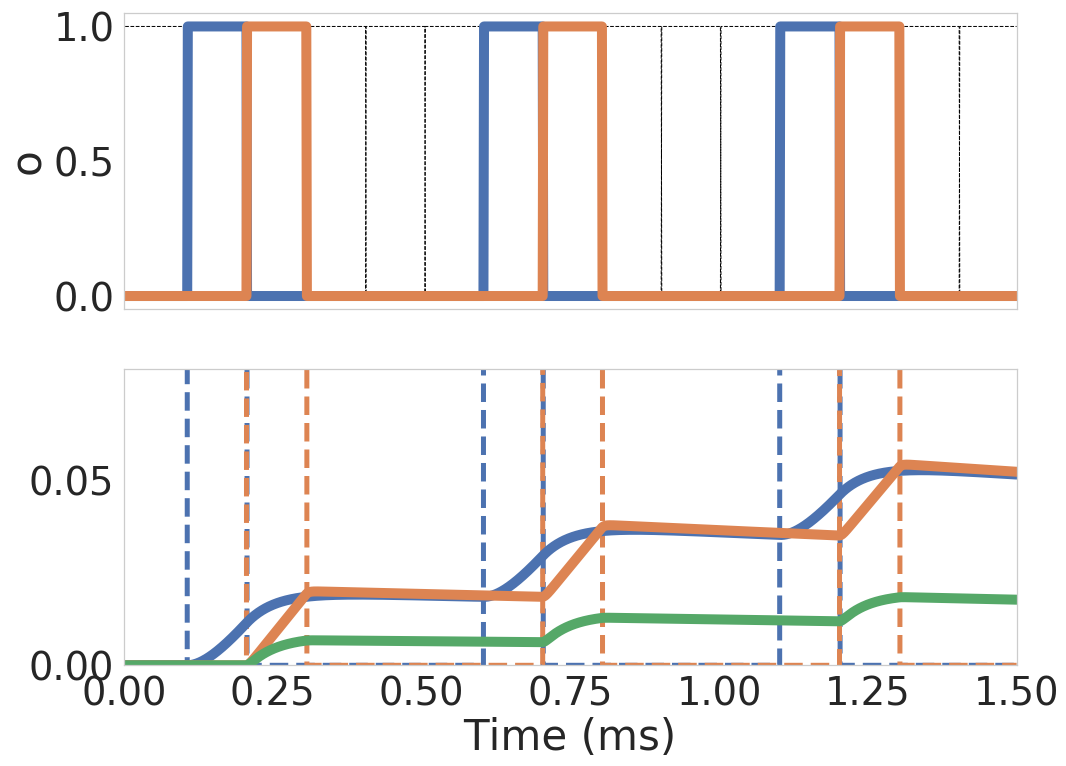

In [131]:
gs = gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(16, 12))

ax_o = fig.add_subplot(gs[0, :])

for index in range(minicolumns):
    ax_o.plot(manager.time, o[:, index], lw=1, color='black', ls='--')

ax_o.plot(manager.time, o[:, 1], lw=lw, color=colors[0])
ax_o.plot(manager.time, o[:, 2], lw=lw, color=colors[1])
    
ax_o.set_ylabel('o')
ax_o.set_xlim([0.0, 1.5])
ax_o.xaxis.set_ticks([])

# The probabilities
p_pre_to_plot = p_pre[:, 1]
p_post_to_plot = p_post[:,2]
P_to_plot = P[:, 2, 1]
ax_prob = fig.add_subplot(gs[1, :])

ax_prob.plot(manager.time, o[:, 1],  lw=lw - 5, color=colors[0], ls='--')
ax_prob.plot(manager.time, o[:, 2], lw=lw - 5,  color=colors[1], ls='--') 

ax_prob.plot(manager.time, p_pre_to_plot, color=colors[0], lw=lw, label=r'$p_{pre}$')
ax_prob.plot(manager.time, p_post_to_plot, color=colors[1], lw=lw, label=r'$p_{post}$')
ax_prob.plot(manager.time, P_to_plot, lw=lw, color=colors[2], label='P')

ax_prob.set_ylim([0, 0.08])
ax_prob.set_xlim([0, 1.5])
ax_prob.yaxis.set_label_position("right")
ax_prob.set_xlabel('Time (ms)')



directory = '../plot_producers/'
file_name = 'prob_evolution' 
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

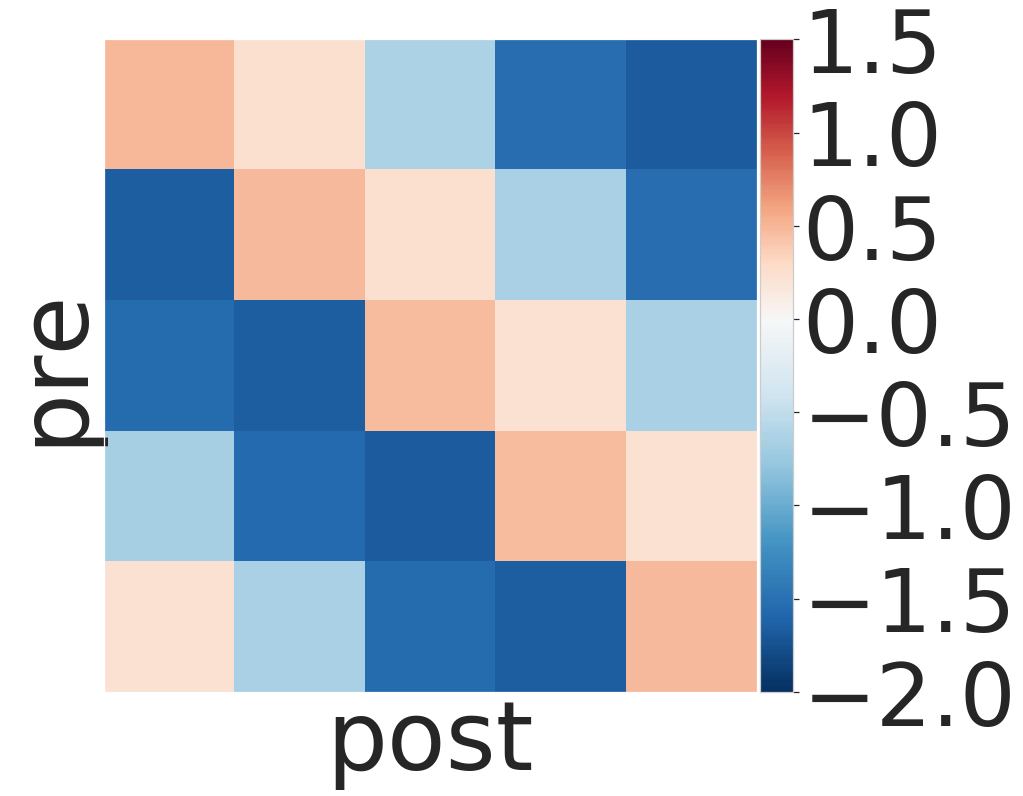

In [155]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 12))
sns.set(font_scale=8.0)


# The matrix at the end
vmin = -2.0
vmax = 1.5
ax_matrix = fig.add_subplot(gs[0, :])
ax_matrix = plot_matrix(manager.nn.w, ax=ax_matrix, title=False, colorbar=True, transpose=True, vmin=vmin, vmax=vmax)
ax_matrix.yaxis.set_ticks([])
ax_matrix.xaxis.set_ticks([])
ax_matrix.set_xlabel('post')
ax_matrix.set_ylabel('pre')

directory = '../plot_producers/'
file_name = 'matrix' 
format_string = '.png'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

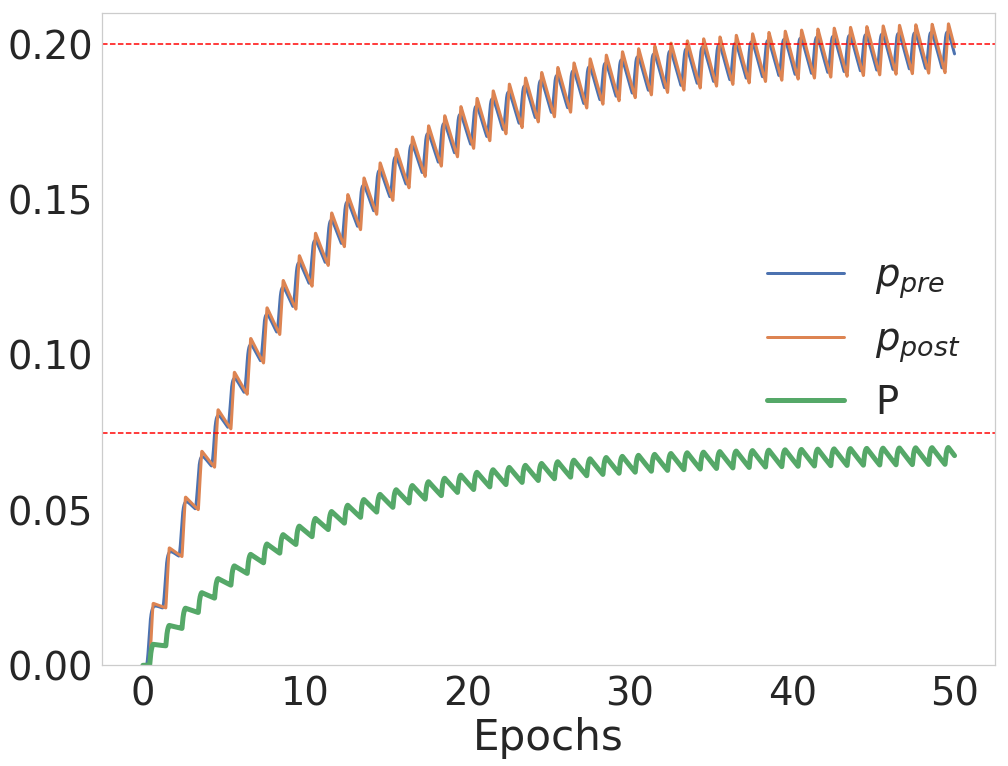

In [133]:
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(16, 12))

# The steady state thing
ax_steady = fig.add_subplot(gs[0, 0])
ax_steady.plot(manager.time / (training_times_base * n_patterns), p_pre_to_plot, lw=3, label=r'$p_{pre}$')
ax_steady.plot(manager.time / (training_times_base * n_patterns), p_post_to_plot, lw=3, label=r'$p_{post}$')
ax_steady.plot(manager.time / (training_times_base * n_patterns), P_to_plot, lw=5, label='P')

ax_steady.legend(frameon=False)


P_steady = (1 - np.exp(-training_times_base / tau_z_pre)) * (1 - np.exp(-training_times_base / tau_z_pre))
P_steady *= (tau_z_pre  / (n_patterns * training_times_base))

ax_steady.axhline(0.20, ls='--', color='red', label=r'$p_{steady}$')
ax_steady.axhline(P_steady, ls='--', color='red', label=r'$p_{steady}$' )

ax_steady.set_xlabel('Epochs')
ax_steady.set_ylim([0, 0.21])
#ax_steady.yaxis.set_ticks([])

directory = '../plot_producers/'
file_name = 'steady_state' 
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

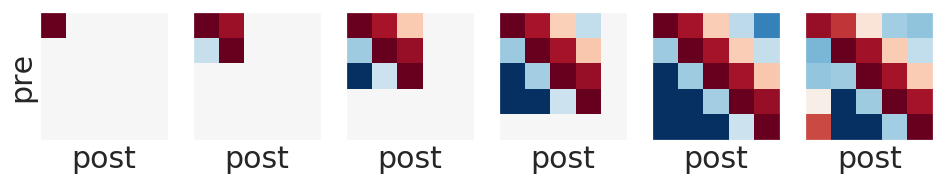

In [156]:
gs = gridspec.GridSpec(1, 6)
fig = plt.figure(figsize=(16, 12))
sns.set(font_scale=2.5)

# Evolution of the matrix
for i in range(6):
    ax = fig.add_subplot(gs[0, i])

    t = (i + 1)/ 10.0
    n_to_plot = int(t/ dt)
    w_to_plot = w[n_to_plot, :, :]
    if i < 5:
        colorbar = False
    else:
        colorbar = False
    ax = plot_matrix(w_to_plot, ax=ax, title=False, colorbar=colorbar, transpose=True, vmin=vmin, vmax=vmax)
    ax.set_xlabel('post')
    if i == 0:
        ax.set_ylabel('pre')
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])

directory = '../plot_producers/'
file_name = 'matrix_evo'
format_string = '.png'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')


# A quick plot for the how P_next behaves as a function of tau_z

In [29]:
def P_next_steady(T1, tau_z_pre, epoch_time):
    
    return (tau_z_pre * (1 - np.exp(-T1 / tau_z_pre)) **2)  / epoch_time

Text(0, 0.5, 'probability')

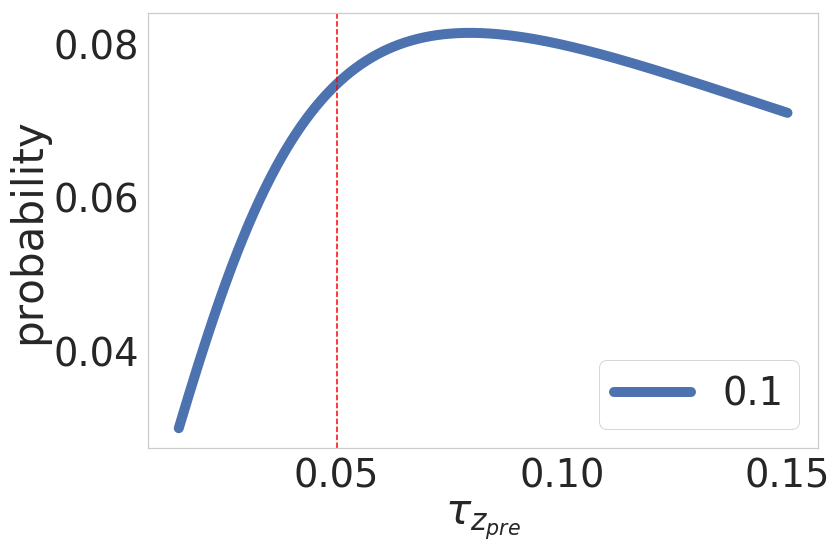

In [36]:
epoch_time = 0.500
tau_z_pre_vector = np.linspace(0.015, 0.150, num=1000)
T1s = [0.100]

for T1 in T1s:
    p_next_steady = P_next_steady(T1, tau_z_pre_vector, epoch_time)
    plt.plot(tau_z_pre_vector, p_next_steady, lw=lw, label=str(T1))
    
plt.legend()
plt.axvline(0.050, ls='--', color='red')
plt.xlabel(r'$\tau_{z_{pre}}$')
plt.ylabel('probability')

Text(0, 0.5, 'probability')

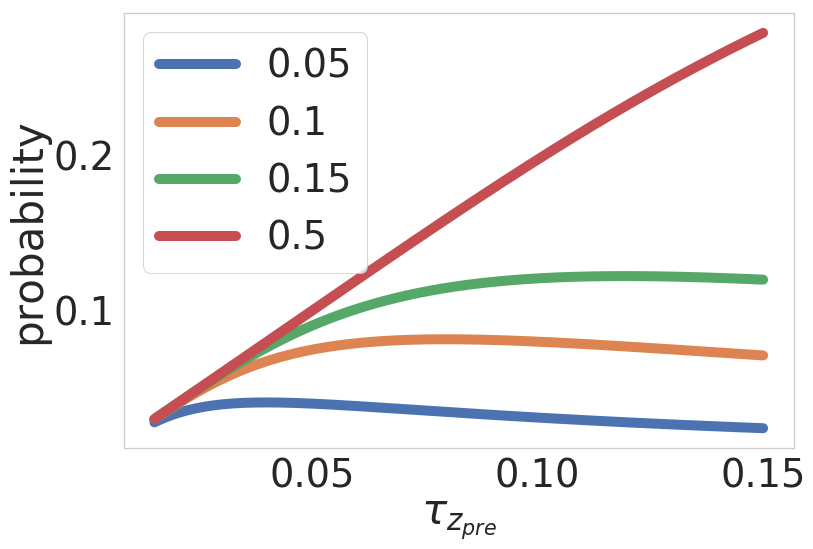

In [34]:
epoch_time = 0.500
tau_z_pre_vector = np.linspace(0.015, 0.150, num=1000)
T1s = [0.050, 0.100, 0.150, 0.500]

for T1 in T1s:
    p_next_steady = P_next_steady(T1, tau_z_pre_vector, epoch_time)
    plt.plot(tau_z_pre_vector, p_next_steady, lw=lw, label=str(T1))
    
plt.legend()
plt.xlabel(r'$\tau_{z_{pre}}$')
plt.ylabel('probability')